In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
image = plt.imread('Downloads/20201007_110604.jpg')

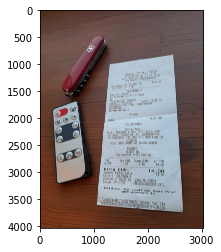

In [3]:
plt.imshow(image)

#### PART 1 : Preprocessing


In [4]:
class Preprocessing:
    def __init__(self,image,kernel_size,sigmaX,threshold1,threshold2,apertureSize):
        self.img = image
        self.ksize = kernel_size
        self.sigma = sigmaX
        self.thresh1 = threshold1
        self.thresh2 = threshold2
        self.apersize = apertureSize
        self.W, self.H, _ = self.img.shape
        self.ratio =500/self.W
        
    def gray(self):
        image = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        return image

    def resize(self,image):
        W,H  = image.shape
        ratio = 500/W
        W = int(W*ratio)
        H = int(H*ratio)
        return cv2.resize(image,(H,W),interpolation = cv2.INTER_AREA), ratio
    
    def blurring(self,image):
        blur = cv2.GaussianBlur(image,self.ksize,self.sigma)
        return blur
    
    def morphological_transformation(self,image):
      ### Here we are perfroming moprpholigical transformation because our receipts are RECTENGEL
        rectkernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9,9)) ##This is the way of dilation 
        ### Dilation this will help to fill the missing area 
        dilation = cv2.dilate(image,rectkernel)
        return dilation
    
    def Canny(self,image):
        image = cv2.Canny(image,self.thresh1,self.thresh2,self.apersize)
        return image
    
    def detect_and_draw_countours(self,image,resize_image):
        res_img = resize_image.copy()
        ## The method we are using are kinda default, Usually we use this 
        countours ,heiraracy  = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_TC89_KCOS)
        largest_countor = sorted(countours,key=cv2.contourArea,reverse=True)[:10] #Top 10 countour
        draw = cv2.drawContours(res_img,largest_countor,-1, (0,255,0), 3)
        plt.imshow(draw)
        return draw,largest_countor
    
    def get_receipt_countr(self,image,largest_countor):
        peri = cv2.arcLength(largest_countor[0],True)
        approx = cv2.approxPolyDP(largest_countor[0],peri*0.032,True)
        for c in largest_countor:
            if len(approx) == 4:return approx
    
    def countr_to_rectangel(self,countr):
        pts = countr.reshape(4,2)
        rect = np.zeros((4, 2), dtype = "float32")
        add =  np.sum(pts,axis=1) ### Top left and right bottom
        differ = np.diff(pts,axis=1) ##### Top Right and Left bottom
        rect[0] = pts[np.argmin(add)]### At what location it was minimum
        rect[2] = pts[np.argmax(add)] #### At what location it was maximum
             
        rect[1] = pts[np.argmin(differ)]
        rect[3] = pts[np.argmax(differ)]
        
        return rect/self.ratio
    
    def wrap_perspective(self,rect):
        (tl, tr, br, bl) = rect
        
        ### Compute the width of New image
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB =  np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        
        ###Compute Height of the New Image
        
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        
        maxWidth = max(int(widthA), int(widthB))
        maxHeight = max(int(heightA), int(heightB))
        
        
        dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
        
        ### Calculate perspective transform matrix
        M = cv2.getPerspectiveTransform(rect, dst) ##### Keep in mind dtype must be in float32
        recipt=cv2.warpPerspective(self.img, M, (maxWidth, maxHeight))
        plt.imshow(recipt)
        return recipt
        
        

        

In [5]:
prep = Preprocessing(image,(3,3),3,100,200,3)

In [6]:
gray_scale = prep.gray()

In [7]:
resize,ratio= prep.resize(gray_scale)

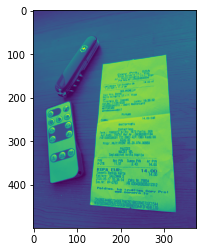

In [8]:
plt.imshow(resize)

In [9]:
blur = prep.blurring(resize)

In [10]:
transofrmation = prep.morphological_transformation(blur)

In [11]:
edge = prep.Canny(transofrmation)

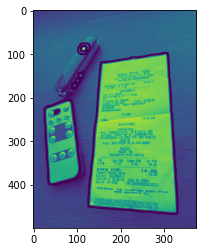

In [12]:
detect_image,largest_countor = prep.detect_and_draw_countours(edge,resize)

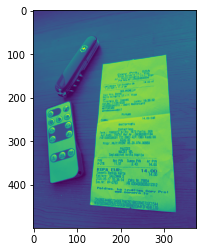

In [13]:
plt.imshow(resize)

In [14]:
receipt_countr = prep.get_receipt_countr(detect_image,largest_countor)

In [15]:
receipt_countr

array([[[308,  98]],

       [[155, 120]],

       [[126, 450]],

       [[330, 466]]], dtype=int32)

In [16]:
#plt.imshow(edge)

In [17]:
cv2.drawContours(resize, receipt_countr, -1, (0,255,0), 3)

array([[38, 40, 41, ..., 89, 91, 89],
       [40, 42, 43, ..., 89, 89, 87],
       [43, 41, 41, ..., 87, 87, 85],
       ...,
       [47, 53, 53, ..., 37, 39, 39],
       [42, 42, 42, ..., 40, 38, 38],
       [48, 46, 48, ..., 40, 40, 40]], dtype=uint8)

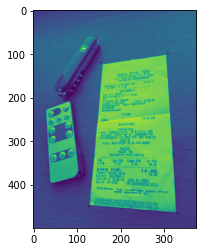

In [18]:
plt.imshow(resize)

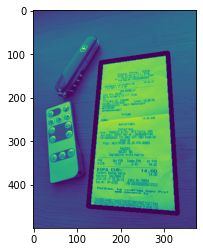

In [19]:
plt.imshow(cv2.drawContours(resize, [receipt_countr], -1, (0,255,0), 9))

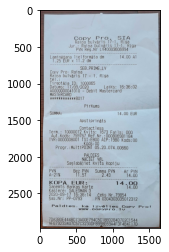

In [20]:
RECT = prep.countr_to_rectangel(receipt_countr)

scanned_document = prep.wrap_perspective(RECT)

### PART 2 : Text Recognition

In [24]:
from paddleocr import PaddleOCR, draw_ocr

In [70]:
class OCR_paddler:
    
    def __init__(self,font_path,language,gpu:bool = False):
        self.path = font_path
        self.models = PaddleOCR(lang = language,use_gpu =False)
        
        
    def ocr(self,image,includes_image: bool =True):
        ocr_ = self.models.ocr(image)
        boxes = [line[0] for line in ocr_]
        txts = [line[1][0] for line in ocr_]
        scores = [line[1][1] for line in ocr_]
        result = {}
        result["boxes"] = np.array(boxes)
        result["text"] = np.array(txts)
        result["confidence"] = np.array(scores)

        if includes_image:
            result["image"] = draw_ocr(
                image, boxes, txts, scores,
                font_path=self.path)

        return result
        

In [71]:
ocr_paddler = OCR_paddler('Downloads/Aaargh/Aaargh.ttf',language='en')

[2021/09/11 18:10:16] root WARNING: lang en is not support in PP-OCRv2, use PP-OCR instead
[2021/09/11 18:10:16] root WARNING: lang en is not support in PP-OCRv2, use PP-OCR instead
[2021/09/11 18:10:16] root WARNING: version PP-OCRv2 not support cls models, use version PP-OCR instead
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/Users/nandrajog/.paddleocr/2.3.0.1/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/Users/nandrajog/.paddleocr/2.3.0.1/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limi

In [72]:
result = ocr_paddler.ocr(scanned_document)

[2021/09/11 18:10:17] root WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2021/09/11 18:10:17] root DEBUG: dt_boxes num : 50, elapse : 0.31072306632995605
[2021/09/11 18:10:18] root DEBUG: rec_res num  : 50, elapse : 1.1695170402526855


In [86]:
str(result['text'])

"['STA' 'Riga' 'Raina bulvaris17-1' 'Jur.:' 'Riga'\n 'PVN Reg.Nr LV40003606994' 'Laminesana Tielformata dm' '14.00A1'\n '1.25 EURx11.2dm' 'SEB_PRIME_LV' 'CopyPro-Raina' 'tel.'\n '1rgotaja ID:1000065' 'Datums:' '17/09/2020' 'LaiKs:16:36:02'\n 'AOOO0000041010' '-Debit Mastercard' 'MASTERCARD' '************8017'\n 'PirKums' 'SUMMA' '14.00EUR' 'Apstiprinats' 'ContactTess'\n 'TVR0000008001 TSI:E800 AIP:1980 Kods00' 'Kods:00' 'PALDIES' 'NACIET VEL'\n 'PVN' 'Summa PVN' 'BezPyN' 'Ar PVN' 'A-21%' '11.57' '2.43' '14.00'\n 'KOPA EUR' '14.00' 'Sanemts BankasKarte' '14.00' '2020-09-1716:36:14'\n 'Ceks Nr.79854' 'Sas.Nr:PP-0793' 'FN 0304303035012312' 'Paldles.' '1211'\n 'Copy Pro' '7DA3B0E444BC73A00E794C5C18BD284D702C1544'\n 'AF879233407C57C3230DF8998E69A4F3F4B4F17D']"

### Part 3 :  How much you spend

In [80]:
import re

In [81]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [88]:
max(find_amounts(str(result['text'])))

14.0

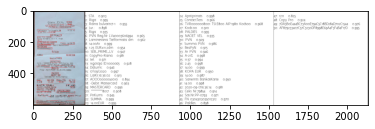

In [75]:
plt.imshow(result['image'])